Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модели на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей 
    
    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm

# 1. Возмем данные из датасета 1-й лабораторной FAANG

In [7]:
df = pd.read_csv('data/Facebook_Historical_StockPrice2.csv')
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,113.320000,114.589996,112.949997,113.690002,113.690002,21351800
1,2016-03-29,113.830002,116.320000,113.639999,116.139999,116.139999,29825300
2,2016-03-30,116.730003,116.989998,114.360001,114.699997,114.699997,33235200
3,2016-03-31,114.699997,115.010002,113.769997,114.099998,114.099998,21207500
4,2016-04-01,113.750000,116.169998,113.349998,116.059998,116.059998,24760500
...,...,...,...,...,...,...,...
1255,2021-03-22,290.450012,299.709991,286.750000,293.540009,293.540009,28273100
1256,2021-03-23,293.149994,298.000000,289.809998,290.630005,290.630005,23000900
1257,2021-03-24,291.000000,291.720001,281.160004,282.140015,282.140015,18675000
1258,2021-03-25,280.980011,288.059998,277.750000,278.739990,278.739990,24505600


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


# 2. Предобработка

Временной ряд сложно предсказывать по дням. Сделаем ряд по месяцам.

In [8]:
df['Month'] = df['Date'].str[:-3]
df = df.loc[df['Month'].between('2016-04', '2021-03')].groupby('Month').agg({
    'Open': lambda x: list(x)[0],
    'High': lambda x: max(x),
    'Low': lambda x: min(x),
    'Close': lambda x: list(x)[-1]
})
df

,Open,High,Low,Close
Month,,,,
2016-04,113.750000,120.790001,106.309998,117.580002
2016-05,117.830002,121.080002,115.879997,118.809998
2016-06,118.500000,119.440002,108.230003,114.279999
2016-07,114.199997,128.330002,112.970001,123.940002
2016-08,123.849998,126.730003,122.070000,126.120003
2016-09,126.379997,131.979996,125.599998,128.270004
2016-10,128.380005,133.500000,126.750000,130.990005
2016-11,131.410004,131.940002,113.550003,118.419998
2016-12,118.379997,122.500000,114.000000,115.050003


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2016-04 to 2021-03
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    60 non-null     float64
 1   High    60 non-null     float64
 2   Low     60 non-null     float64
 3   Close   60 non-null     float64
dtypes: float64(4)
memory usage: 2.3+ KB


In [10]:
df.describe()

,Open,High,Low,Close
count,60.000000,60.000000,60.000000,60.000000
mean,178.789667,192.252835,168.338499,181.224333
std,45.618588,51.294509,42.709280,46.313198
min,113.750000,119.440002,106.309998,114.279999
25%,149.390003,153.997505,136.845005,150.797497
50%,173.714996,187.200005,165.779999,176.095001
75%,194.887501,209.119995,186.957493,196.150005
max,294.709991,304.670013,264.630005,293.200012


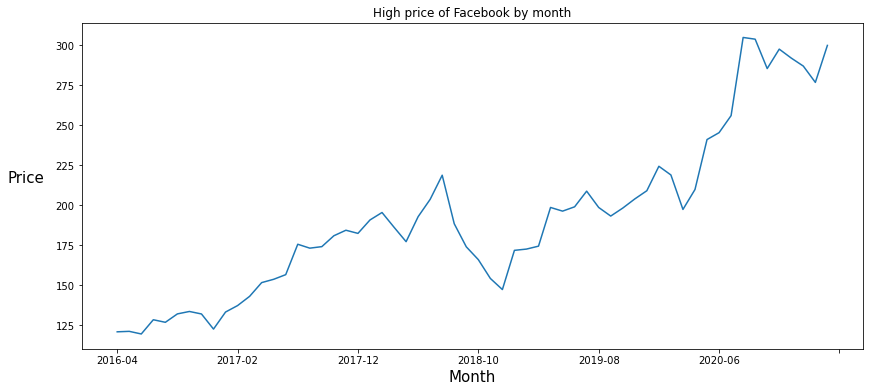

In [11]:
plt.figure(figsize=(14, 6))
plt.title('High price of Facebook by month')
plt.xlabel('Month', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['High'].plot();

<AxesSubplot:title={'center':'Residual'}, xlabel='Month'>

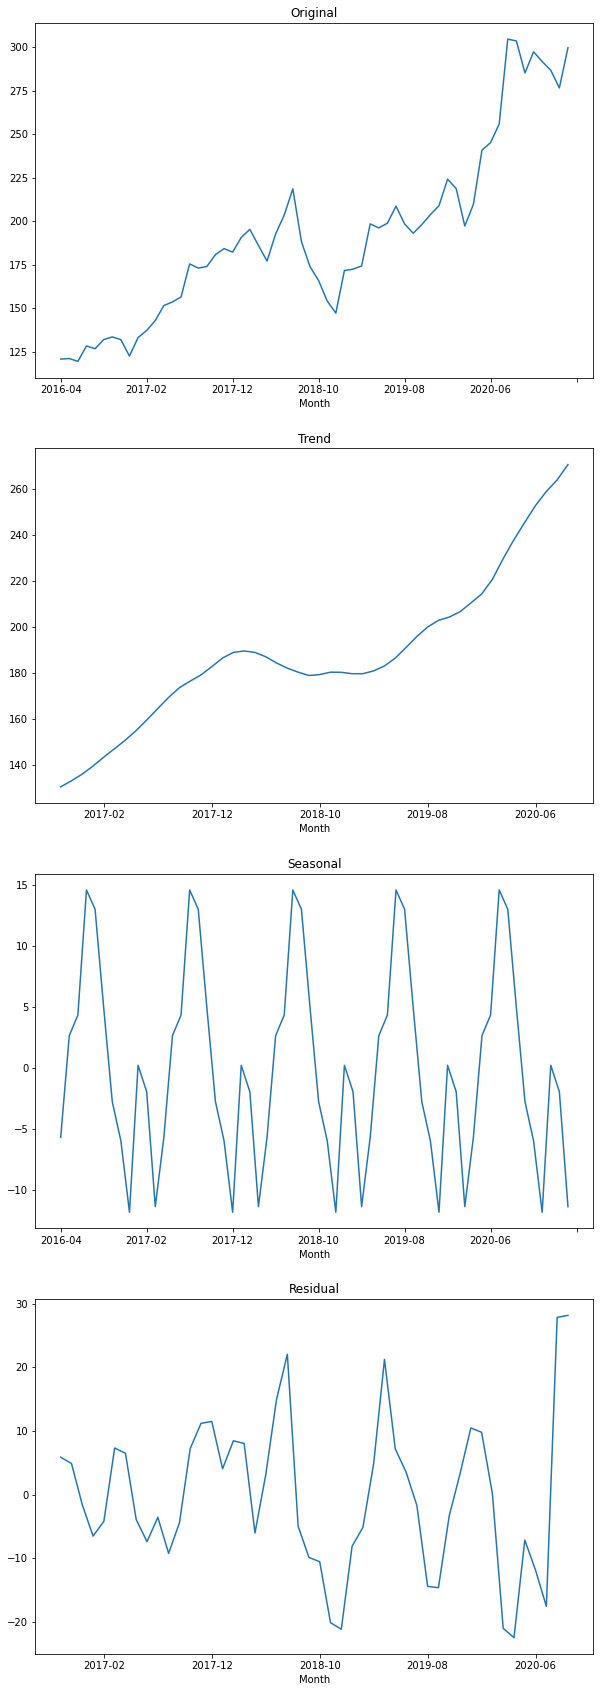

In [12]:
fig, fig_ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 30))
decompose = seasonal_decompose(df[['High']], period=12)

fig_ax[0].set_title('Original')
fig_ax[1].set_title('Trend')
fig_ax[2].set_title('Seasonal')
fig_ax[3].set_title('Residual')

decompose.observed.plot(ax=fig_ax[0])
decompose.trend.plot(ax=fig_ax[1])
decompose.seasonal.plot(ax=fig_ax[2])
decompose.resid.plot(ax=fig_ax[3])

Из графиков видим, что тренд присутствует, следовательно, нужно от него избавиться и привести ряд к стационарному виду.

Проведем сначала логарифмическое, а затем дифференциальное преобразование.

<AxesSubplot:title={'center':'Residual'}, xlabel='Month'>

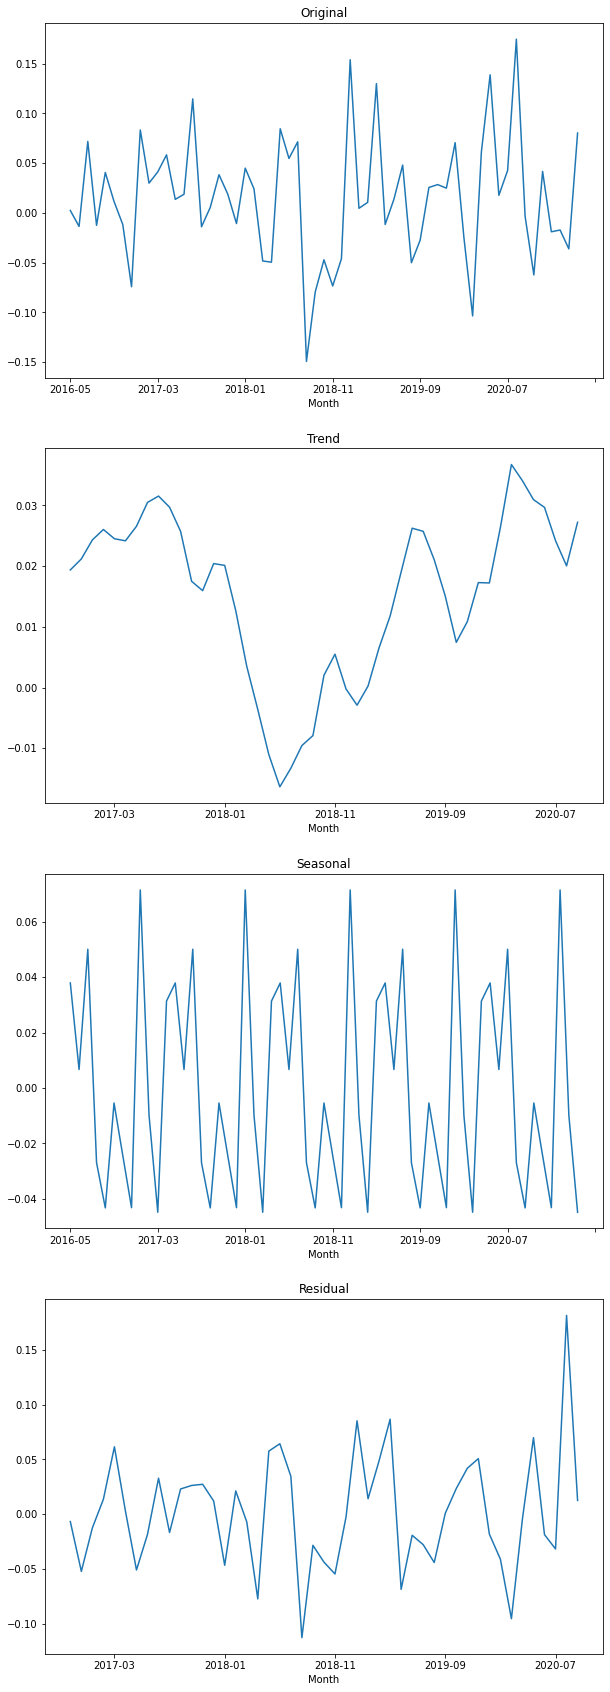

In [14]:
df['HighLog'] = np.log(df['High'])
df['HighLogDiff'] = df['HighLog'].diff()
fig, fig_ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 30))
decompose = seasonal_decompose(df[1:][['HighLogDiff']], period=12)

fig_ax[0].set_title('Original')
fig_ax[1].set_title('Trend')
fig_ax[2].set_title('Seasonal')
fig_ax[3].set_title('Residual')

decompose.observed.plot(ax=fig_ax[0])
decompose.trend.plot(ax=fig_ax[1])
decompose.seasonal.plot(ax=fig_ax[2])
decompose.resid.plot(ax=fig_ax[3])

In [15]:
p_value = adfuller(df['HighLogDiff'][1:])[1]
print("P-Value: " + str(p_value))

P-Value: 0.00010268256719695209


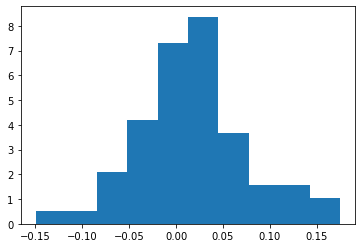

In [16]:
plt.hist(df['HighLogDiff'], density=True);

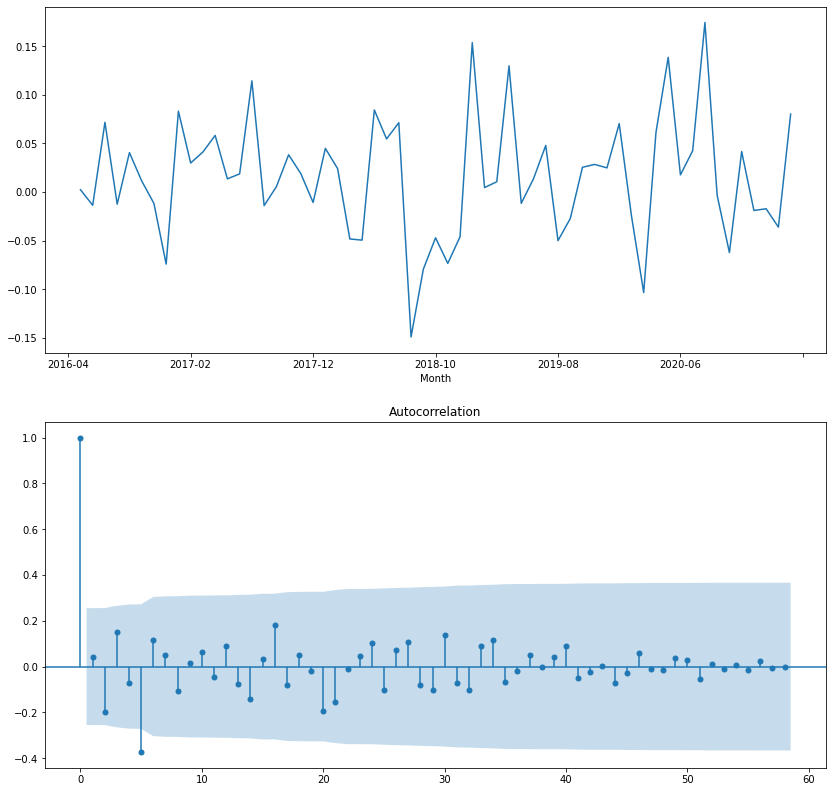

In [17]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df['HighLogDiff'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['HighLogDiff'][1:], lags=df['HighLogDiff'].size - 2, ax=ax);

Получили стационарный ряд.

# 3. Обучим модель

In [32]:
qs = range(1, 5) # номер последнего несезонного лага, для которого автокорреляция значима
Qs = range(1, 3) # номер последнего сезонного лага, для которого автокорреляция значима

ps = range(1, 5) # номер последнего несезонного лага, для которого частичная автокорреляция значима
Ps = range(3, 5) # номер последнего сезонного лага, для которого частичная автокорреляция значима

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

C:\Users\t8965\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


64

In [33]:
train_size = round((df['HighLog'].size - 2) * 0.8)
train_size

46

In [34]:
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')
for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['HighLog'][:train_size],
            order=(param[0], 1, param[1]),
            seasonal_order=(param[2], 1, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:54<00:00,  3.66s/it]


In [35]:
predicted_values = best_model.predict(start=train_size + 1, end=df['HighLog'].size).to_frame()
predicted_values.index = predicted_values.index.strftime('%Y-%m')
predicted_values.head()

C:\Users\t8965\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,predicted_mean
2020-03,5.428377
2020-04,5.432169
2020-05,5.477802
2020-06,5.509779
2020-07,5.602153


In [36]:
df['HighLogPredicted'] = predicted_values
df['HighPredicted'] = np.exp(df['HighLogPredicted'])
df

C:\Users\t8965\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,HighLog,HighLogDiff,HighLogPredicted,HighPredicted
Month,,,,,,,,
2016-04,113.750000,120.790001,106.309998,117.580002,4.794054,NaN,NaN,NaN
2016-05,117.830002,121.080002,115.879997,118.809998,4.796451,0.002398,NaN,NaN
2016-06,118.500000,119.440002,108.230003,114.279999,4.782814,-0.013637,NaN,NaN
2016-07,114.199997,128.330002,112.970001,123.940002,4.854605,0.071791,NaN,NaN
2016-08,123.849998,126.730003,122.070000,126.120003,4.842059,-0.012546,NaN,NaN
2016-09,126.379997,131.979996,125.599998,128.270004,4.882650,0.040591,NaN,NaN
2016-10,128.380005,133.500000,126.750000,130.990005,4.894101,0.011451,NaN,NaN
2016-11,131.410004,131.940002,113.550003,118.419998,4.882347,-0.011754,NaN,NaN
2016-12,118.379997,122.500000,114.000000,115.050003,4.808111,-0.074236,NaN,NaN


C:\Users\t8965\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


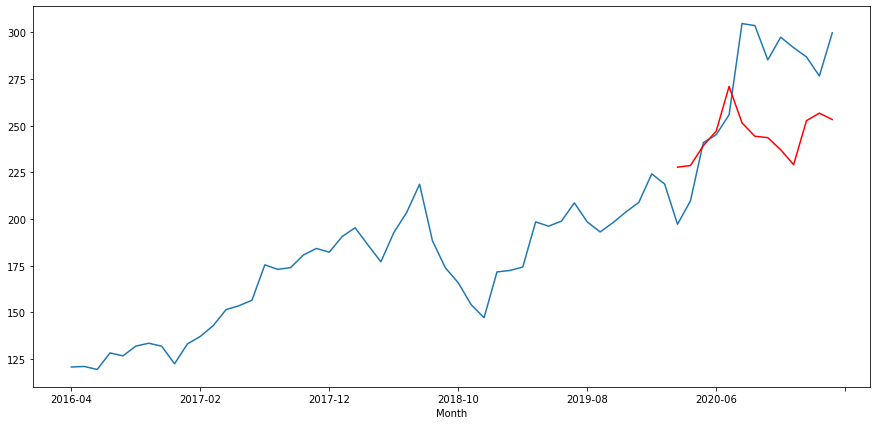

In [37]:
plt.figure(figsize=(15, 7))
df['High'].plot()
df['HighPredicted'].plot(c='r');

# MAPE

In [31]:
mape = mean_absolute_percentage_error(df['High'][train_size + 1:], df['HighPredicted'][train_size + 1:])
print("MAPE: " + str(mape))

MAPE: 0.1393916878115663


C:\Users\t8965\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
